In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
#import joblib  # Use this instead of sklearn.externals.joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
%matplotlib inline

In [2]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import the dataset and give the column names
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv(r'C:\Users\ssp1_\Downloads\ratings_Electronics.csv',names=columns)

In [5]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
electronics_df.drop('timestamp',axis=1,inplace=True)

In [7]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [8]:
#Check the number of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


In [9]:
electronics_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [10]:
#Taking subset of the dataset
electronics_df1=electronics_df.iloc[:50000,0:]

In [11]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [12]:
#Summary statistics of rating variable
electronics_df1['ratings'].describe().transpose()

count    50000.00000
mean         4.03524
std          1.35555
min          1.00000
25%          4.00000
50%          5.00000
75%          5.00000
max          5.00000
Name: ratings, dtype: float64

In [13]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.ratings.min()))
print('Maximum rating is: %d' %(electronics_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [14]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


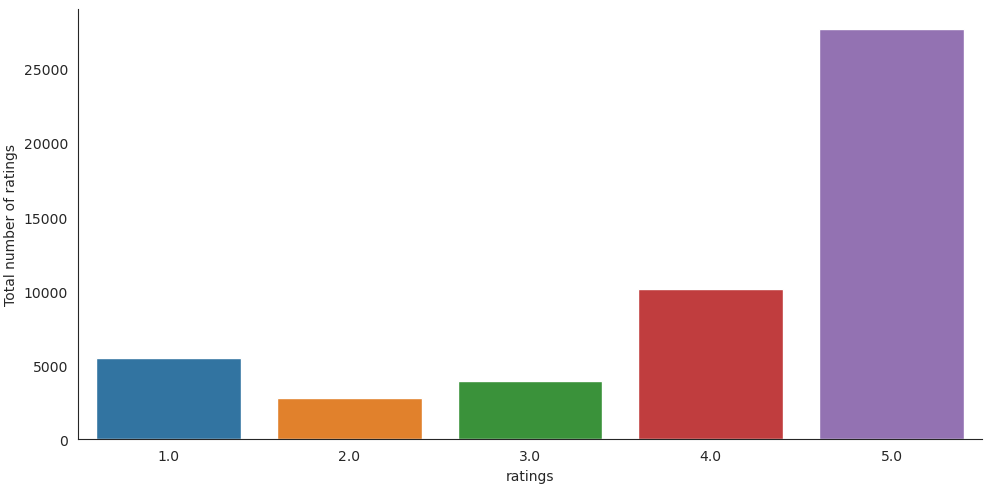

In [16]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.catplot(x="ratings", data=electronics_df1, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")

In [17]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df1['productId'].nunique())

Number of unique users in Raw data =  46554
Number of unique product in Raw data =  3446


In [18]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A231WM2Z2JL0U3    37
AY8Q1X7G96HV5     31
ALUNVOQRXOZIA     20
A1NVD0TKNS1GT5    19
A243HY69GIAHFI    18
A1RPTVW5VEOSI     17
A1ISUNUWG0K02V    16
A1MJMYLRTZ76ZX    16
A7Y6AVS576M03     15
A3MEIR72XKQY88    15
dtype: int64


In [19]:
counts=electronics_df1.userId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 219
Number of unique users in the final data =  11
Number of unique products in the final data =  11


In [20]:
#constructing the pivot table
final_ratings_matrix = electronics_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [21]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (11, 186)


In [22]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  219
possible_num_of_ratings =  2046
density: 10.70%


In [23]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
17509,AY8Q1X7G96HV5,B00000JSES,4.0
11968,A243HY69GIAHFI,B00000J3Q7,3.0
35533,A1RPTVW5VEOSI,B00003WGP5,5.0
31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
13526,A23ZO1BVFFLGHO,B00000J570,5.0


In [24]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (153, 3)
Shape of testing data:  (66, 3)


Building Popularity Recommder model

In [26]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,1400599997,1
1,B00000DM9M,1
2,B00000J061,1
3,B00000J08C,1
4,B00000J1QZ,1
5,B00000J3HB,1
6,B00000J3II,2
7,B00000J3Q7,1
8,B00000J3T1,1
9,B00000J47A,1


In [27]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productId,score,rank
87,B00004RC2D,4,1.0
57,B00002SWHH,3,2.0
99,B00004SC3Y,3,3.0
100,B00004SCKA,3,4.0
6,B00000J3II,2,5.0


In [28]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [29]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the userId: 10

     userId   productId  score  rank
87       10  B00004RC2D      4   1.0
57       10  B00002SWHH      3   2.0
99       10  B00004SC3Y      3   3.0
100      10  B00004SCKA      3   4.0
6        10  B00000J3II      2   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
87      100  B00004RC2D      4   1.0
57      100  B00002SWHH      3   2.0
99      100  B00004SC3Y      3   3.0
100     100  B00004SCKA      3   4.0
6       100  B00000J3II      2   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
87      150  B00004RC2D      4   1.0
57      150  B00002SWHH      3   2.0
99      150  B00004SC3Y      3   3.0
100     150  B00004SCKA      3   4.0
6       150  B00000J3II      2   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

Collaborative Filtering recommender model.

In [30]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,17509,AY8Q1X7G96HV5,B00000JSES,4.0
1,11968,A243HY69GIAHFI,B00000J3Q7,3.0
2,35533,A1RPTVW5VEOSI,B00003WGP5,5.0
3,31480,A1NVD0TKNS1GT5,B00002JXFH,4.0
4,13526,A23ZO1BVFFLGHO,B00000J570,5.0


User Based Collaborative Filtering model

In [32]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0


In [33]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (11, 186)


In [34]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1ISUNUWG0K02V,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1RPTVW5VEOSI,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,4


In [35]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

productId,1400599997,B00000DM9M,B00000J061,B00000J08C,B00000J0A2,B00000J0E8,B00000J1QZ,B00000J1US,B00000J3H5,B00000J3HB,...,B00004TDWY,B00004TE75,B00004TEN2,B00004TH2W,B00004TH2Y,B00004THCX,B00004THCY,B00004THCZ,B00004THDE,B00004THM6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0
